# import libraries


In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython import display

# define parameters

In [ ]:
LEARNING_RATE = 0.0001
BETA1 = 0.5
OPTIMIZER_D = tf.optimizers.Adam(lr=LEARNING_RATE, beta_1=BETA1)
OPTIMIZER_G = tf.optimizers.Adam(lr=LEARNING_RATE, beta_1=BETA1)
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

INPUT_LENGTH = 64

EPOCHS = 200
BATCH_SIZE = 128

OUTPUT_SIZE = 28
OUTPUT_CHANNELS = 1

# load data

In [ ]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype('float32')
x_train = (x_train - 127.5)/127.5
IMAGE_SHAPE = x_train[0].shape

print(x_train.shape)
print(np.max(x_train))

(60000, 28, 28, 1)
1.0


In [ ]:
# Batch and shuffle the data
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(BATCH_SIZE, drop_remainder=True)

# define model

### generator

In [ ]:
def generator(input_dim=10, output_channels=1, hidden_channel=64):
    model = tf.keras.models.Sequential()

    model.add(Layers.Reshape((1, 1, input_dim), input_shape=(input_dim,)))
    model.add(Layers.Conv2DTranspose(hidden_channel*4, 3, 2))
    model.add(Layers.BatchNormalization())
    model.add(Layers.ReLU())

    model.add(Layers.Conv2DTranspose(hidden_channel*2, 5, 1))
    model.add(Layers.BatchNormalization())
    model.add(Layers.ReLU())

    model.add(Layers.Conv2DTranspose(hidden_channel, 3, 2))
    model.add(Layers.BatchNormalization())
    model.add(Layers.ReLU())

    model.add(Layers.Conv2DTranspose(1, 5, 2, activation='tanh'))
    model.summary()
    return model

### discriminator

In [ ]:
def discriminator(input_dim=28, hidden_channel=64):
    model = tf.keras.models.Sequential()

    model.add(Layers.Conv2D(hidden_channel*2, 4, 2, input_shape=(input_dim,input_dim,1)))
    model.add(Layers.BatchNormalization())
    model.add(Layers.LeakyReLU(0.2))

    model.add(Layers.Conv2D(hidden_channel, 4, 2))
    model.add(Layers.BatchNormalization())
    model.add(Layers.LeakyReLU(0.2))

    model.add(Layers.Conv2D(1, 4, 2, activation='sigmoid'))
    model.summary()
    return model

# Full model

In [ ]:
gen = generator(INPUT_LENGTH, OUTPUT_CHANNELS)
discr = discriminator(OUTPUT_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 256)         147712    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 256)         1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 128)         0

# Define train step

In [ ]:
def get_noise(input_dim, num_samples):
    return tf.random.normal((num_samples, input_dim))

In [ ]:
def get_discr_loss(gen, discr, real, input_dim, num_samples):
    noise = get_noise(input_dim, num_samples)
    fake_images = gen(noise)
    fake_pred = discr(fake_images)
    real_pred = discr(real)
    fake_loss = BCE(fake_pred, tf.zeros_like(fake_pred))
    real_loss = BCE(real_pred, tf.ones_like(real_pred))
    return (real_loss+fake_loss)/2

In [ ]:
def get_gen_loss(gen, discr, input_dim, num_samples):
    noise = get_noise(input_dim, num_samples)
    fake_images = gen(noise)
    fake_pred = discr(fake_images)
    gen_loss = BCE(fake_pred, tf.ones_like(fake_pred))
    return gen_loss

In [ ]:
@tf.function
def train_step(gen, discr, real, input_dim):
    num_samples = len(real)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        gen_loss = get_gen_loss(gen, discr, input_dim, num_samples)
        discr_loss = get_discr_loss(gen, discr, real, input_dim, num_samples)
    gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
    discr_grads = discr_tape.gradient(discr_loss, discr.trainable_variables)
    OPTIMIZER_D.apply_gradients(zip(discr_grads, discr.trainable_variables))
    OPTIMIZER_G.apply_gradients(zip(gen_grads, gen.trainable_variables))
    return (gen_loss, discr_loss)

# Train model

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
seed = get_noise(INPUT_LENGTH, 16)

In [ ]:
def print_weight_matrices(model):
    weights = []
    for l in model.layers:
      if l.trainable == True:
        weights.append(l.get_weights()[0])
    #print(len(weights))
    fig = plt.figure(figsize=(4, 4))
    for i in range(len(weights)):
        plt.subplot(4, 4, i+1)
        plt.imshow(weights[i], cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
def train(x_train, gen, discr, input_dim, epochs):
    for e in range(epochs):
      start = time.time()
      for image_batch in x_train:
          gen_loss, discr_loss = train_step(gen, discr, image_batch, input_dim)
      # Produce images for the GIF as we go
      display.clear_output(wait=True)
      generate_and_save_images(gen, e + 1, seed)
      #print_weight_matrices(gen)
      #print_weight_matrices(discr)
      print("Loss - gen: {}, discr: {}".format(gen_loss, discr_loss))
      # print("Accuracy - gen: {}, discr: {}".format(gen_acc, discr_acc))
      print ('Time for epoch {} is {} sec'.format(e + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(gen, epochs, seed)


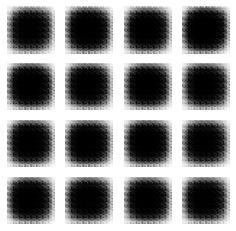

Loss - gen: 0.3132617473602295, discr: 0.5032045841217041
Time for epoch 30 is 7.656724214553833 sec


In [ ]:
train(x_train, gen, discr, INPUT_LENGTH, EPOCHS)

# Generate new images

In [ ]:
num_images = 10
noise = get_noise(INPUT_LENGTH, num_images)
generated_images = gen(noise, training=False)*127.5+127.5

# View generated images

In [ ]:
plt.imshow(np.squeeze(generated_images[np.random.randint(num_images)]), cmap='gray')